In [1]:
import pandas as pd
import ast
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
labels = pd.read_csv("./data/labels.csv")
embedding_row_ids = pd.read_csv("./data/embedding_row_ids.csv")

In [18]:
cbc = pd.read_csv("../pre_processing/lab_train/cbc_data.csv")


In [23]:
cbc.rename(columns={"HadmId": "hadm_id"}, inplace=True)

In [24]:
cbc

,hadm_id,51222,51250,51265,51279,51301
0,20000019,9.2,86.0,183.0,3.09,15.7
1,20000024,10.3,98.0,196.0,3.27,4.9
2,20000034,9.4,95.0,157.0,3.19,11.2
3,20000041,9.5,89.0,229.0,3.16,7.4
4,20000057,12.8,98.0,154.0,3.93,8.4
...,...,...,...,...,...,...
302470,29999670,10.6,91.0,151.0,3.50,4.6
302471,29999723,14.3,88.0,234.0,4.54,7.7
302472,29999745,14.0,82.0,238.0,4.68,5.5
302473,29999809,12.7,89.0,196.0,4.25,7.3


In [4]:
embeddings = np.load("./data/embedding.npy")

In [5]:
embedding_row_ids["idx"] = embedding_row_ids.index

In [6]:
embedding_row_ids  = embedding_row_ids.rename(columns={"0": "row_id"})

In [39]:
merged_embedding_row_ids = pd.merge(embedding_row_ids, labels, on="row_id", how = "left")

In [40]:
merged_embedding_row_ids = pd.merge(merged_embedding_row_ids, cbc, on="hadm_id", how = "left")
merged_embedding_row_ids = merged_embedding_row_ids.sort_values(by=["idx"])

In [54]:
cbc_vals = merged_embedding_row_ids.loc[:, ['51222', '51250', '51265', '51279',
       '51301']].values
non_nan_mask = np.isnan(cbc_vals).sum(-1) == 0

In [96]:
X = np.concatenate([embeddings, cbc_vals], axis = 1)

In [97]:
X, y = X[non_nan_mask], merged_embedding_row_ids["label"].values[non_nan_mask]

In [98]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score # Example metric
from sklearn.ensemble import RandomForestClassifier # Example model
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope # For hp.quniform to ensure integer types

def hyperparameter_tuning(train_X, train_y, model_class, space, metric_func, 
                          max_evals=100, cv_folds=5, random_state_cv=42,
                          metric_needs_proba=True):
    """
    Performs hyperparameter tuning for a given scikit-learn model using Hyperopt.

    Args:
        train_X (pd.DataFrame or np.ndarray): Features for training.
        train_y (pd.Series or np.ndarray): Target variable for training.
        model_class (class): The scikit-learn model class (e.g., RandomForestClassifier).
        space (dict): Hyperopt search space definition.
        metric_func (callable): A metric function from sklearn.metrics or compatible.
                                 It should accept (y_true, y_pred_or_proba).
                                 Assumed that higher is better.
        max_evals (int): Maximum number of evaluations for Hyperopt.
        cv_folds (int): Number of folds for StratifiedKFold cross-validation.
        random_state_cv (int): Random state for StratifiedKFold and Hyperopt's TPE algorithm
                               for reproducible results.
        metric_needs_proba (bool): True if the metric_func requires probability scores
                                   (e.g., roc_auc_score). False if it needs class predictions.

    Returns:
        tuple: (best_params, trials_object)
               best_params (dict): Dictionary of the best hyperparameters found.
               trials_object (hyperopt.Trials): Hyperopt trials object containing history.
               Returns (None, trials_object) if optimization fails or no successful trial.
    """

    # Ensure train_X and train_y are in a consistent format (e.g. pandas for .iloc)
    # If numpy arrays are passed, internal indexing will handle them.
    is_pandas = hasattr(train_X, 'iloc') and hasattr(train_y, 'iloc')

    def objective(params):
        """
        Objective function for Hyperopt to minimize.
        It calculates the negative average cross-validated score.
        """
        # Ensure integer types for parameters that need them, if not already handled by space definition
        # For example, n_estimators, max_depth etc. hp.quniform with q=1 and scope.int handles this.
        # If params come from hp.choice that result in float for an int param, cast them:
        # e.g., if 'max_depth' in params and params['max_depth'] is not None:
        #    params['max_depth'] = int(params['max_depth'])

        current_model_params = params.copy()
        
        # Example: If space defines 'max_depth_options' which is a choice,
        # you might need to unpack it here into 'max_depth'.
        # For this generic function, we assume `params` keys directly match model args.
        print(current_model_params)
        model = model_class(**current_model_params)
        
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state_cv)
        scores = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(train_X, train_y)):
            if is_pandas:
                X_train_fold, X_val_fold = train_X.iloc[train_idx], train_X.iloc[val_idx]
                y_train_fold, y_val_fold = train_y.iloc[train_idx], train_y.iloc[val_idx]
            else: # Assuming numpy arrays
                X_train_fold, X_val_fold = train_X[train_idx], train_X[val_idx]
                y_train_fold, y_val_fold = train_y[train_idx], train_y[val_idx]
            
            try:
                model.fit(X_train_fold, y_train_fold)
                
                if metric_needs_proba:
                    if hasattr(model, "predict_proba"):
                        # Probability of the positive class (usually class 1)
                        preds = model.predict_proba(X_val_fold)[:, 1] 
                    else:
                        # Fallback or error if model can't predict_proba but metric needs it
                        print(f"Warning: Metric {metric_func.__name__} needs probabilities, "
                              f"but model {model_class.__name__} may lack predict_proba. Trying predict().")
                        preds = model.predict(X_val_fold) # Or raise an error
                else:
                    preds = model.predict(X_val_fold)
                    
                score = metric_func(y_val_fold, preds)
                print(score)
                scores.append(score)
            except ValueError as ve: # Catches errors like "Only one class present in y_true." for roc_auc
                print(f"ValueError in fold {fold+1} with params {params}: {ve}. Skipping fold.")
                # Optionally, append a very bad score or handle as per strategy
            except Exception as e:
                print(f"Error during model training/prediction in fold {fold+1} with params {params}: {e}")
                # Return a very bad score to penalize these parameters for this trial
                return {'loss': np.inf, 'status': STATUS_OK, 'params': params, 'error': str(e)} 

        if not scores: # All folds failed for this set of params
             print(f"All CV folds failed for params: {params}")
             return {'loss': np.inf, 'status': STATUS_OK, 'params': params, 'error': 'All CV folds failed'}

        avg_score = np.mean(scores)
        
        # Hyperopt minimizes, so return negative of a score to be maximized
        return {'loss': -avg_score, 'status': STATUS_OK, 'params': params, 'mean_cv_score': avg_score}

    trials = Trials()
    
    # np.random.default_rng is preferred for newer NumPy versions for reproducibility with Hyperopt
    rstate = np.random.default_rng(random_state_cv)

    try:
        best_params_from_fmin = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials,
            rstate=rstate,
            return_argmin=True # fmin returns the actual arg values, not just indices for hp.choice
        )
    except Exception as e:
        print(f"An error occurred during hyperopt.fmin: {e}")
        return None, trials

    # fmin returns the best parameters. For hp.choice, it returns the actual values.
    # The trials object also stores the best trial information.
    if trials.best_trial and trials.best_trial['result']['status'] == STATUS_OK:
        # The 'params' in best_trial['result'] are the actual parameters used.
        best_actual_params = trials.best_trial['result']['params'] #space_eval(trials.best_trial['result']['params'])
        best_score = trials.best_trial['result']['mean_cv_score'] # Or -trials.best_trial['result']['loss']
        
        print(f"\nHyperparameter tuning complete.")
        print(f"Best average {metric_func.__name__} achieved: {best_score:.5f}")
        print(f"Best parameters found: {best_actual_params}")
        return best_actual_params, trials
    else:
        print("\nHyperparameter tuning finished, but no successful trial was found or best trial had issues.")
        # best_params_from_fmin might still hold something if fmin completed but trials object is odd.
        # However, relying on trials.best_trial is generally safer.
        if best_params_from_fmin:
            print(f"fmin suggested parameters: {best_params_from_fmin} (may not correspond to a valid trial if errors occurred)")
        return None, trials 

In [100]:
rf_space_example = {
        'n_estimators': scope.int(hp.quniform('n_estimators', 50, 250, 25)), # e.g., 50, 75, ..., 250
        'max_depth': hp.choice('max_depth', [None] + list(range(5, 21, 5))),  # e.g., [None, 5, 10, 15, 20]
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 15, 1)), # e.g., 2, 3, ..., 15
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 15, 1)),   # e.g., 1, 2, ..., 15
        'criterion': hp.choice('criterion', ['gini', 'entropy']),
        'max_features': hp.choice('max_features', ['sqrt', 'log2']), # 'auto' is sqrt for RF
        'class_weight': hp.choice('class_weight', [None, 'balanced', 'balanced_subsample']),
        'random_state': 42,  # Fixed for reproducibility of the RF model itself during evaluations
    "n_jobs": 5
}

print("Starting hyperparameter tuning for RandomForestClassifier...")
# Using roc_auc_score which needs probabilities
best_rf_params, trials_rf = hyperparameter_tuning(
    train_X=train_X[:30000],
    train_y=train_y[:30000],
    model_class=RandomForestClassifier,
    space=rf_space_example,
    metric_func=roc_auc_score,
    metric_needs_proba=True, # roc_auc_score needs probabilities
    max_evals=50,  # Reduced for quicker example run; increase for real tasks (e.g., 50-200)
    cv_folds=3     # Reduced for quicker example run; typically 5 or 10
)

Starting hyperparameter tuning for RandomForestClassifier...
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 13, 'min_samples_split': 10, 'n_estimators': 225, 'n_jobs': 5, 'random_state': 42}
0.7451471466933464                                    
0.7462657498983877                                    
0.7393729921827175                                    
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 13, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': 5, 'random_state': 42}
0.7048895900423471                                                                  
0.702172113777926                                                                   
0.7060742939796631                                                                  
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 

In [94]:
model = RandomForestClassifier(**{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 13, 'n_estimators': 175, 'n_jobs': 5, 'random_state': 42})
#{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 11, 'min_samples_split': 5, 'n_estimators': 175, 'n_jobs': 5, 'random_state': 42}) #best_rf_params
model.fit(train_X[:50_000], train_y[:50_000])
predictions = model.predict(test_X)
print(metrics.classification_report(test_y, predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     12037
           1       0.33      0.00      0.00       638

    accuracy                           0.95     12675
   macro avg       0.64      0.50      0.49     12675
weighted avg       0.92      0.95      0.93     12675



In [95]:
metrics.roc_auc_score(test_y, model.predict_proba(test_X)[:, 1]), metrics.average_precision_score(test_y, model.predict_proba(test_X)[:, 1])

(np.float64(0.7748375372382387), np.float64(0.1801381697292772))

In [79]:
from sklearn.metrics import roc_curve, f1_score, precision_recall_curve


def estimate_best_threshold(model, X_val, y_val, num_thresholds=100, metric='f1'):
    """
    Estimates the best probability threshold for a scikit-learn model on an imbalanced dataset.

    The function iterates through a range of possible thresholds for the predicted
    probabilities and selects the threshold that maximizes the chosen metric.

    Args:
        model: A trained scikit-learn classifier with a `predict_proba` method.
        X_val: Validation features (numpy array or pandas DataFrame).
        y_val: True labels for the validation set (numpy array or pandas Series).
        num_thresholds (int): The number of threshold values to evaluate between 0 and 1.
                              This is used for 'f1' and 'gmean' metrics.
                              It's ignored if 'pr_curve' or 'roc_curve' is used.
        metric (str): The metric to optimize. Options:
                      'f1': F1-score (default)
                      'gmean': Geometric Mean of sensitivity and specificity
                      'pr_curve': Uses precision-recall curve to find the threshold that
                                  maximizes F1-score.
                      'roc_curve': Uses ROC curve to find the threshold that maximizes
                                   Youden's J statistic (TPR - FPR).

    Returns:
        float: The threshold value that maximizes the chosen metric.
        float: The best score achieved for the chosen metric.
               For 'roc_curve', this is the Youden's J statistic.

    Raises:
        ValueError: If the model does not have a `predict_proba` method or
                    if an unsupported metric is chosen.
    """
    # Ensure the model has predict_proba
    if not hasattr(model, "predict_proba"):
        raise ValueError("Model does not have a predict_proba method.")

    # Get probability predictions for the positive class
    # Assumes the positive class is the second column (index 1)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    best_threshold = 0.5  # Default threshold
    best_score = -1.0     # Initialize with a value that will be beaten

    if metric == 'f1':
        thresholds = np.linspace(0.0, 1.0, num_thresholds + 1) # +1 to include 0.0 and 1.0
        for threshold in thresholds:
            # Convert probabilities to binary predictions based on the current threshold
            y_pred_binary = (y_pred_proba >= threshold).astype(int)
            # Calculate F1 score
            score = f1_score(y_val, y_pred_binary)
            if score > best_score:
                best_score = score
                best_threshold = threshold
    elif metric == 'gmean':
        thresholds = np.linspace(0.0, 1.0, num_thresholds + 1)
        for threshold in thresholds:
            y_pred_binary = (y_pred_proba >= threshold).astype(int)
            # Calculate True Positives, False Positives, True Negatives, False Negatives
            tp = np.sum((y_val == 1) & (y_pred_binary == 1))
            fn = np.sum((y_val == 1) & (y_pred_binary == 0))
            tn = np.sum((y_val == 0) & (y_pred_binary == 0))
            fp = np.sum((y_val == 0) & (y_pred_binary == 1))

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            score = np.sqrt(sensitivity * specificity)

            if score > best_score:
                best_score = score
                best_threshold = threshold
    elif metric == 'pr_curve':
        # Use precision-recall curve to find the best threshold
        precision, recall, thresholds_pr = precision_recall_curve(y_val, y_pred_proba)
        # Calculate F1 score for each threshold from the PR curve
        f1_scores_pr = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9) # Add epsilon

        if len(f1_scores_pr) > 0:
            best_idx = np.argmax(f1_scores_pr)
            best_score = f1_scores_pr[best_idx]
            best_threshold = thresholds_pr[best_idx]
        else:
            print("Warning: Precision-recall curve did not yield valid F1 scores. Falling back to 0.5 threshold.")
            y_pred_binary_fallback = (y_pred_proba >= 0.5).astype(int)
            best_score = f1_score(y_val, y_pred_binary_fallback)
            best_threshold = 0.5
    elif metric == 'roc_curve':
        # Use ROC curve to find the best threshold (Youden's J statistic)
        fpr, tpr, thresholds_roc = roc_curve(y_val, y_pred_proba)
        youden_j = tpr - fpr # Youden's J statistic
        
        if len(youden_j) > 0:
            best_idx = np.argmax(youden_j)
            best_score = youden_j[best_idx] # Store Youden's J as the score
            best_threshold = thresholds_roc[best_idx]
            # Handle cases where threshold might be > 1 (occurs if all predictions are 0)
            if best_threshold > 1.0:
                 best_threshold = 1.0
        else:
            # Fallback if roc_curve doesn't yield scores
            print("Warning: ROC curve did not yield valid Youden's J scores. Falling back to 0.5 threshold.")
            y_pred_binary_fallback = (y_pred_proba >= 0.5).astype(int)
            # For consistency, calculate F1 if ROC fails, or decide on a default Youden's J
            tp = np.sum((y_val == 1) & (y_pred_binary_fallback == 1))
            fn = np.sum((y_val == 1) & (y_pred_binary_fallback == 0))
            tn = np.sum((y_val == 0) & (y_pred_binary_fallback == 0))
            fp = np.sum((y_val == 0) & (y_pred_binary_fallback == 1))
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            best_score = sensitivity + specificity -1
            best_threshold = 0.5

    else:
        raise ValueError(f"Unsupported metric: {metric}. Choose from 'f1', 'gmean', 'pr_curve', or 'roc_curve'.")

    return best_threshold, best_score

In [80]:
estimate_best_threshold(model, train_X[50_000:], train_y[50_000:])

(np.float64(0.22), 0.2564102564102564)

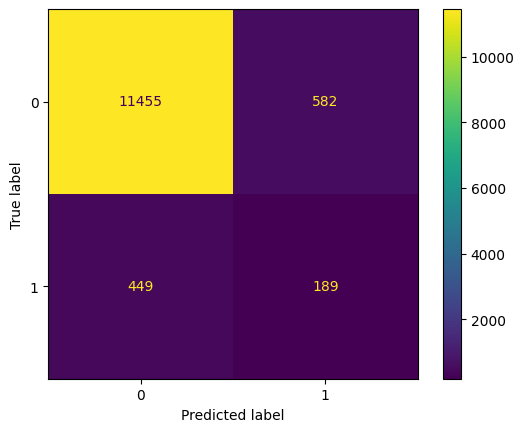

In [84]:

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict_proba(test_X)[:,-1]>.22
cm = confusion_matrix(test_y, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

In [16]:
# import numpy as np
# from annoy import AnnoyIndex
# import time
# import random
# 
# # 1. Define Parameters
# dimension = 5000
# num_vectors = 10000
# num_queries = 5
# k = 3
# metric = 'angular' # 'angular' for cosine similarity, 'euclidean', 'manhattan'
# 
# print(f"Vector Dimension: {dimension}")
# print(f"Number of Database Vectors: {num_vectors}")
# print(f"Metric: {metric}\n")
# 
# # 2. Generate Random Database Vectors
# print("Generating database vectors...")
# np.random.seed(42)
# database_vectors = train_X
# 
# # 4. Build the Annoy Index
# print(f"\nBuilding Annoy index (metric: {metric})...")
# annoy_index = AnnoyIndex(train_X.shape[-1], metric)
# start_time = time.time()
# for i, vec in enumerate(database_vectors):
#     annoy_index.add_item(i, vec)
# 
# # Build the index (n_trees affects accuracy and build time)
# # More trees generally means better accuracy but longer build time and larger index.
# annoy_index.build(n_trees=20) # Adjust n_trees as needed
# end_time = time.time()
# print(f"Index built in {end_time - start_time:.4f} seconds.")
# 
# # Optionally, save and load the index
# # annoy_index.save('my_index.ann')
# # loaded_index = AnnoyIndex(dimension, metric)
# # loaded_index.load('my_index.ann')
# # annoy_index = loaded_index # Use the loaded index


Vector Dimension: 5000
Number of Database Vectors: 10000
Metric: angular

Generating database vectors...

Building Annoy index (metric: angular)...
Index built in 14.4463 seconds.


In [17]:
# # 3. Generate Random Query Vectors
# print("\nGenerating query vectors...")
# query_vectors = train_X[:30000]
# 
# # 5. Perform the Search
# print(f"\nSearching for {k} nearest neighbors ...")
# search_results = []
# start_time = time.time()
# for q_vec in query_vectors:
#     # search_k: Number of nodes to inspect during search. -1 means default (n_trees * k).
#     # Higher search_k gives more accuracy but is slower.
#     indices, distances = annoy_index.get_nns_by_vector(q_vec, k, search_k=-1, include_distances=True)
#     search_results.append((indices, distances))
# end_time = time.time()
# print(f"Search completed in {end_time - start_time:.4f} seconds.")


Generating query vectors...

Searching for 3 nearest neighbors for 5 queries...
Search completed in 430.0262 seconds.
